# 4. lyricist : 멋진 작사가 만들기

## 목차

> <p style="font-size:17px">4.1 데이터 다운로드</p>
  <p style="font-size:17px">4.2 데이터 읽어오기</p> 
  <p style="font-size:17px">4.3 데이터 정제</p>
  <p style="font-size:17px">4.4 평가 데이터셋 분리</p>
  <p style="font-size:17px">4.5 인공지능 만들기</p>


## 루브릭 (프로젝트 평가 기준)

> |<p style="font-size:15px"> 평가문항 </p>                                |<p style="font-size:15px"> 상세기준 </p>        |
  |------------------------------------------------------------------------|------------------------------------------------|
  | 1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?                      |텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?|
  | 2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?     |특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?|
  | 3. 텍스트 생성모델이 안정적으로 학습되었는가?                          |텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?|

## 4.1 데이터 다운로드
* .txt 파일들로 준비된 데이터 파일을 다운로드 받아서 폴더 안에 넣어주겠습니다.

## 4.2 데이터 읽어오기
* glob 모듈을 사용하여 모든 .txt 파일을 읽어와서 raw_corput 변수에 리스트 형태로 넣어주겠습니다.
* 데이터 정제 전 크기: 187088

In [1]:
import glob
import os, re
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/explore4_lyrics/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

# raw_corpus 안에 있는 데이터 크기와 데이터를 확인 합니다. 
print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth', 'The minor fall, the major lift', 'The baffled king composing Hallelujah Hallelujah', 'Hallelujah', 'Hallelujah', 'Hallelujah Your faith was strong but you needed proof']


In [2]:
# raw_corpus 안에 있는 텍스트들을 한 줄씩 확인 해보겠습니다. 
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.
    if idx > 10: break   
        
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof
You saw her bathing on the roof


## 4.3 데이터 정제
* raw_corpus 안에 있는 데이터를 확인하고 정제를 진행하도록 하겠습니다. 
* preprocess_sentence() 함수를 만들어서 이를 활용해 데이터를 정제하겠습니다.

In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는 결과를 확인합니다.
print(preprocess_sentence("This, @_is ;;;sample        sentence."))

<start> this , is sample sentence . <end>


In [4]:
# corpus에 정제된 문장을 모으겠습니다.
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다.
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    
    # preprocessed_sentence() 함수로 데이터를 정제하고 corpus에 담습니다.
    # <start>와 <end>를 포함하고 17개 그리고 포함하지않고는 15개의 토큰을 가진 데이터만 corpus에 담습니다.
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split(" ")) > 17: continue
           
    corpus.append(preprocessed_sentence)
        
# 정제된 결과 10개를 확인합니다.
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

### Tokenizer
* Tensorflow 에서 제공하는 Tokenizer 패키지를 사용해서 corpus에 있는 데이터를 텐서로 변환하겠습니다.
* 기억할 수 있는 단어를 15,000개로 지정하겠습니다.
* preprocess_sentence 함수를 사용해서 이미 문장들을 정제했으니 filters가 필요없습니다.
* 15,000단어에 포함되지 못한 단어는 "unk"로 바꾸겠습니다.
---
* corpus를 이용해 tokenizer 내부의 단어장을 완성합니다.
---
* 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다.
---
* 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
* 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다. (padding = 'post')

In [5]:
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )

    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)   
      
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2927 ...    0    0    0]
 [   2   32    7 ...    0    0    0]
 ...
 [   2  260  192 ...    0    0    0]
 [   2  132    4 ...   10 1070    3]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f045031aa90>


* tokenize() 함수를 사용해서 만든 텐서를 확인합니다.

In [6]:
print(tensor[:10])
tensor.shape

[[    2    50     4    95   307    62    55     9   972  5996     3     0
      0     0     0     0     0]
 [    2    15  2927   869     5     8    11  5997     6   358     3     0
      0     0     0     0     0]
 [    2    32     7    37    16   164   288    28   334     5    48     7
     44     3     0     0     0]
 [    2    11   344    24    42     3     0     0     0     0     0     0
      0     0     0     0     0]
 [    2     6  4211     5     6  2100     3     0     0     0     0     0
      0     0     0     0     0]
 [    2     6  5584   292     5     6  1200   766     3     0     0     0
      0     0     0     0     0]
 [    2     6  8950   511 12877  1010  1010     3     0     0     0     0
      0     0     0     0     0]
 [    2  1010     3     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2  1010     3     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [    2  1010    20   894    55   550

(163488, 17)

* tokenizer() 함수를 사용해서 구축된 단어 사전의 인덱스를 확인합니다.

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 30: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : that
16 : t
17 : s
18 : on
19 : of
20 : your
21 : we
22 : .
23 : m
24 : like
25 : all
26 : is
27 : be
28 : for
29 : up
30 : with


In [8]:
#  tensor에서 마지막 토큰을 잘라서 소스 문장을 생성합니다. 
   # 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
# tensor에서 처음 토큰을 잘라서 타겟 문장을 생성합니다. 
   # 처음 토큰은 <start>일 가능성이 높습니다. 
    
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  307   62   55    9  972 5996    3    0    0    0
    0    0]
[  50    4   95  307   62   55    9  972 5996    3    0    0    0    0
    0    0]


## 4.4 평가 데이터셋 분리
* train_test_split을 사용하여 학습 데이터와 테스트 데이터로 분류 하겠습니다.
* 학습 데이터와 테스트 데이터 비율을 8:2로 지정하겠습니다. 

In [9]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state = 30)

print("학습 소스 세트: ", enc_train.shape)
print("학습 타겟 세트: ", dec_train.shape)

학습 소스 세트:  (130790, 16)
학습 타겟 세트:  (130790, 16)


* enc_train과 dec_train으로 학습을 진행합니다. 
* enc_val과 dec_val으로 validation을 진행합니다. 

In [10]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

validation = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
validation = validation.shuffle(BUFFER_SIZE)
validation = validation.batch(BATCH_SIZE, drop_remainder=True)
validation

<BatchDataset shapes: ((256, 16), (256, 16)), types: (tf.int32, tf.int32)>

## 4.5 인공지능 만들기

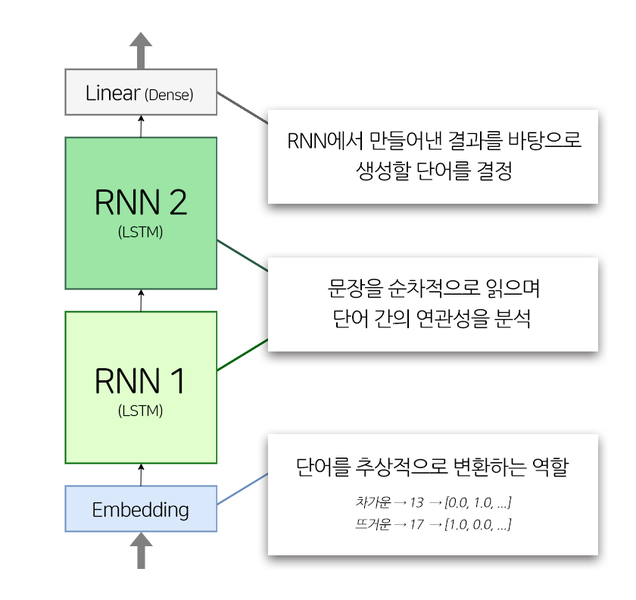

* 1개의 Embedding 레이어, 2개의 LSTM 레이어 그리고 1개의 Dense 레이어로 구성되어있습니다.

**Enbedding 레이어**
- Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 줍니다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됩니다.
- 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 그만큼 충분한 데이터가 주어지지 않으면 **오히려 혼란**만을 야기할 수 있습니다. 

**Hidden 사이즈**
- hidden size는 모델의 일꾼 수를 뜻하기도 합니다. 
- 이 또한 충분한 데이터가 주어지지 않으면 일꾼들이 **혼란**에 빠질 수 있습니다.

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

#기억하는 단어수 를 12000에서 올리면, embedding과 hidden도 오려야 함
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 16, 15001), dtype=float32, numpy=
array([[[ 1.73555498e-04,  2.58000829e-04, -1.82840668e-04, ...,
          6.17635524e-05, -1.42381623e-05,  3.09637951e-04],
        [-2.83141097e-04,  7.36866612e-04, -3.36856727e-04, ...,
         -1.32514237e-04, -2.67494674e-04,  4.19927092e-04],
        [-3.82862549e-04,  1.07127137e-03, -3.32511350e-04, ...,
         -4.95979912e-04, -2.76965235e-04,  5.07649616e-04],
        ...,
        [-5.38194785e-04, -6.61601603e-04, -1.10915198e-03, ...,
          2.50435733e-06, -1.53304555e-03,  8.02353199e-04],
        [-6.25858782e-04, -7.28164159e-04, -1.21129164e-03, ...,
          2.41953152e-04, -1.40981434e-03,  9.21852014e-04],
        [-9.16668854e-04, -1.30981777e-03, -1.19714322e-03, ...,
          8.15851890e-05, -1.42710772e-03,  1.05496543e-03]],

       [[ 1.73555498e-04,  2.58000829e-04, -1.82840668e-04, ...,
          6.17635524e-05, -1.42381623e-05,  3.09637951e-04],
        [ 4.61737887e-04,  5.92975062e-04, -1

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7680512   
_________________________________________________________________
lstm (LSTM)                  multiple                  20979712  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  30737049  
Total params: 92,959,897
Trainable params: 92,959,897
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, 
    reduction='none')

* 데이터를 학습 시켰을때 10번째 에폭에서 **loss가 1.2271** 그리고 **val_loss가 2.0128**까지 떨어진 것을 확인할 수 있습니다. 

In [15]:
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, epochs=10, validation_data=validation)

Epoch 1/10
510/510 [==============================] - 349s 680ms/step - loss: 3.0982 - val_loss: 2.7348
Epoch 2/10
510/510 [==============================] - 348s 683ms/step - loss: 2.6130 - val_loss: 2.5404
Epoch 3/10
510/510 [==============================] - 348s 682ms/step - loss: 2.3951 - val_loss: 2.4014
Epoch 4/10
510/510 [==============================] - 348s 682ms/step - loss: 2.1956 - val_loss: 2.2953
Epoch 5/10
510/510 [==============================] - 348s 681ms/step - loss: 2.0077 - val_loss: 2.2117
Epoch 6/10
510/510 [==============================] - 348s 682ms/step - loss: 1.8299 - val_loss: 2.1473
Epoch 7/10
510/510 [==============================] - 348s 682ms/step - loss: 1.6611 - val_loss: 2.0958
Epoch 8/10
510/510 [==============================] - 348s 682ms/step - loss: 1.5025 - val_loss: 2.0560
Epoch 9/10
510/510 [==============================] - 347s 681ms/step - loss: 1.3572 - val_loss: 2.0303
Epoch 10/10
510/510 [==============================] - 348s 681m

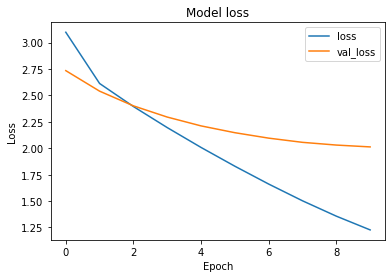

In [16]:
import matplotlib.pyplot as plt

# 학습 그래프 [loss & val_loss]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

* 학습을 진행한 작문 모델을 직접 만들게 시켜보고 평가 해보겠습니다. 

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

* mushroom 이라는 단어를 입력했을 때는 중간에 "unk"이 나오면서 완벽한 문작을 작문하지 못하였습니다.    

In [25]:
generate_text(model, tokenizer, init_sentence="<start> mushroom ", max_len=20)

'<start> mushroom , i ve been a <unk> , i m a legend <end> '

* 애플사의 mac 이란 단어를 넣었을 때, ' 부호는 없지만 mac'n'cheese의 맛에 대한 작문이 나왔습니다: mac's got the flavor

In [27]:
generate_text(model, tokenizer, init_sentence="<start> mac ", max_len=20)

'<start> mac s got the flavor <end> '

* soccer 라는 단어를 넣었을 때, 완벽히 말이 되는 작문은 아니지만 작문을 하여 문장을 만들어 냈습니다. 

In [28]:
generate_text(model, tokenizer, init_sentence="<start> soccer ", max_len=20)

'<start> soccer that , pop that , cock and reload <end> '

| trial # | num_words | batch_size | embedding_size | hidden_size | loss   | val_loss |
|---------|-----------|------------|----------------|-------------|--------|----------|
|    1    | 12000     | 256        | 256            | 1024        | 0.9534 | 2.6621   |
|    2    | 24000     | 256        | 307            | 1229        | 1.2821 | 2.4865   |
|    3    | 15000     | 256        | 512            | 3072        | 0.8533 | 2.4970   |
|    4    | 15000     | 256        | 512            | 4096        | 0.9626 | 2.3542   |
|    5    | 24000     | 256        | 512            | 4096        | 0.9196 | 2.3362   |
| final   | **15000**     | **256**        | **512**            | **2048**        | **1.2271** | **2.0128**   |**

* 위의 그래프는 마지막 가장 낮은 val_loss 값이 얻어질 때까지 parameters를 변경해가며 모델을 학습한 결과입니다. 
* val_loss가 줄어들 수록 embedding_size는 늘어났지만, 유의한 결과 트렌드를 발견하진 못했습니다.
* num_words가 24000일 때, loss는 1이 넘는 숫자를 나타냈지만 val_loss의 값과는 유의한 트렌드가 없었습니다. 
* 변경했던 파라미터들 보단 마지막에 파라미터 (num_words: 15000, batch_size: 256, embedding_size: 512, hidden_size: 2048, loss: 1.2271, val_loss: 2.0128)를 유지하고 train/validation 데이터를 나눌 때, random_state 숫자를 바꿔서 train/valication 데이터에 변화를 준 것이 val_loss를 낮추는데 더욱 효과적이였습니다. 
    * 이는 데이터의 양이 너무 적어서 파라미터들을 변경했을 때, 적절한 역할을 하지 못했던 것 같습니다. 

Trial 1
---
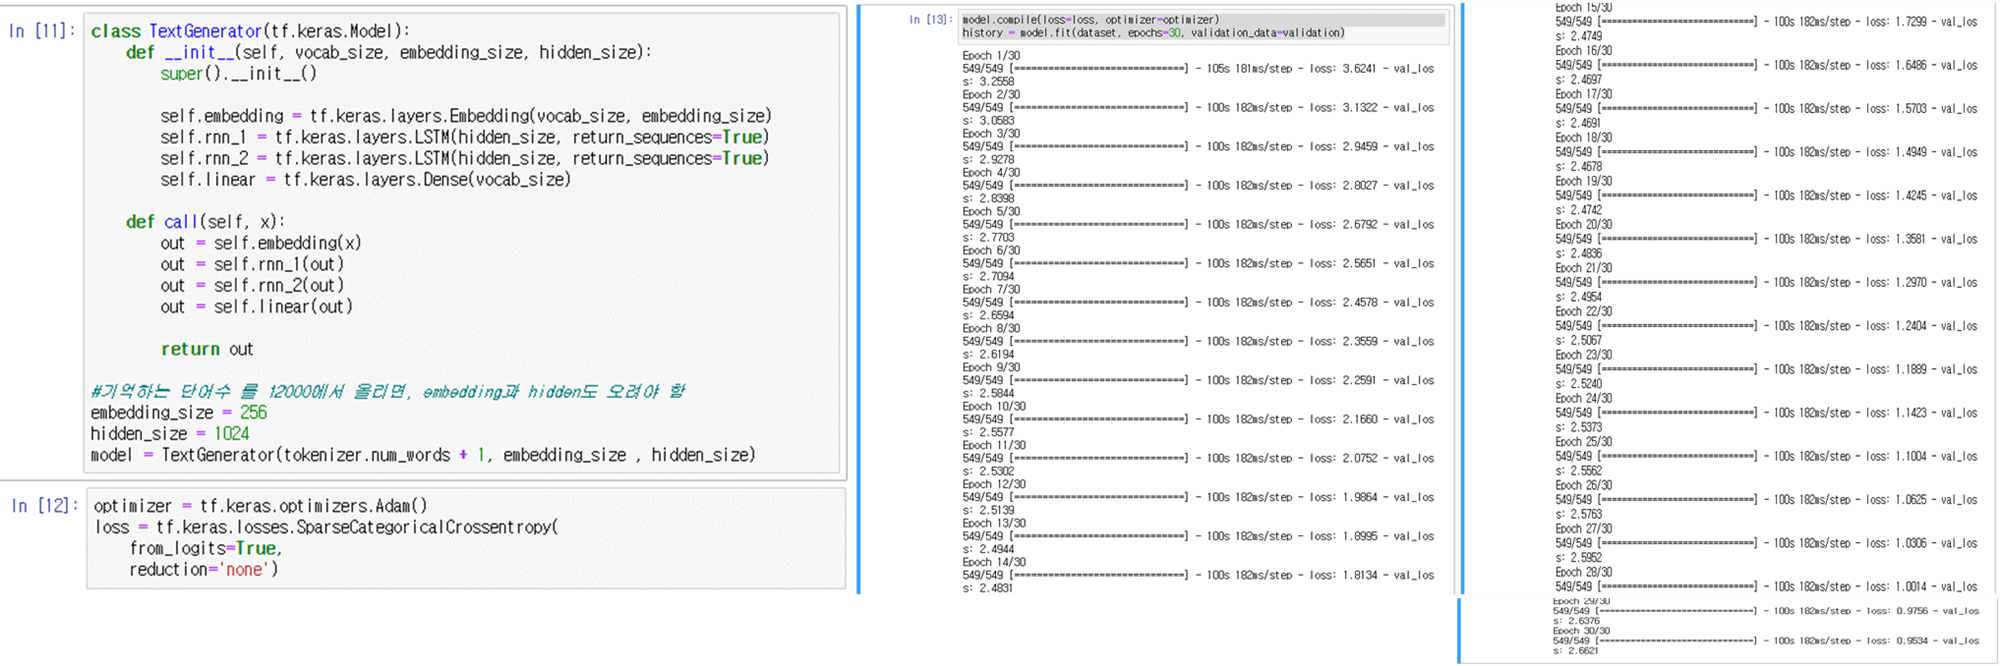
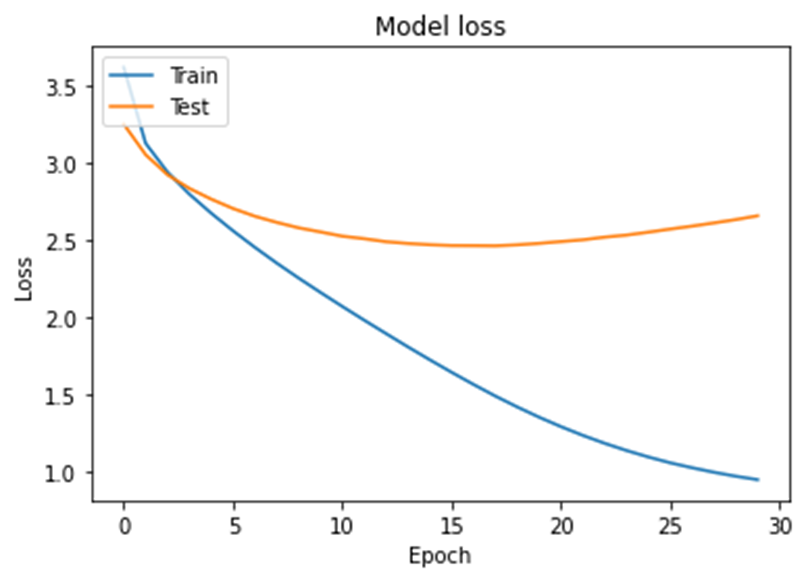

Trial 2
---
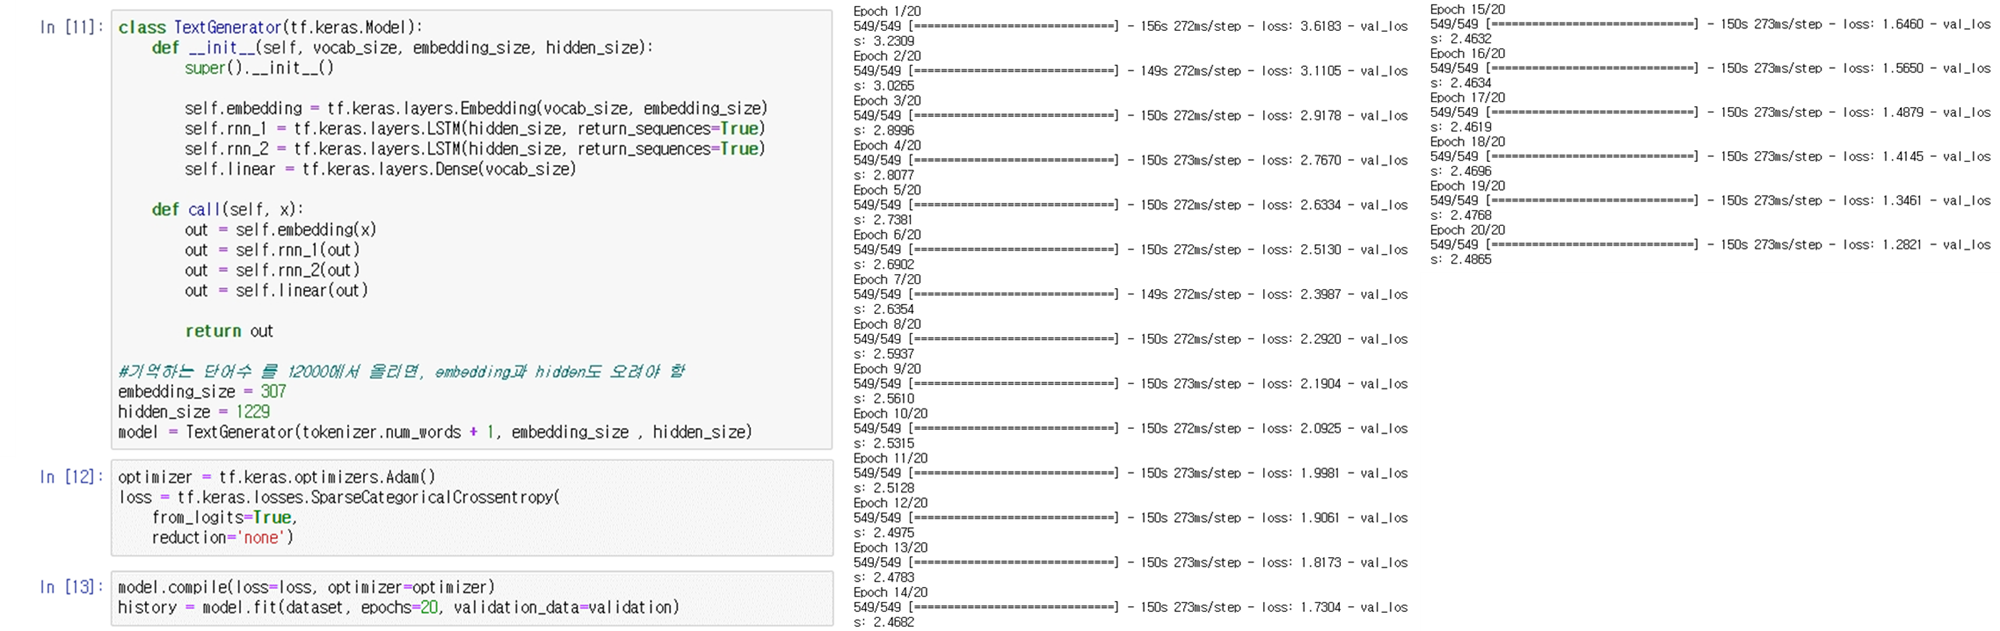
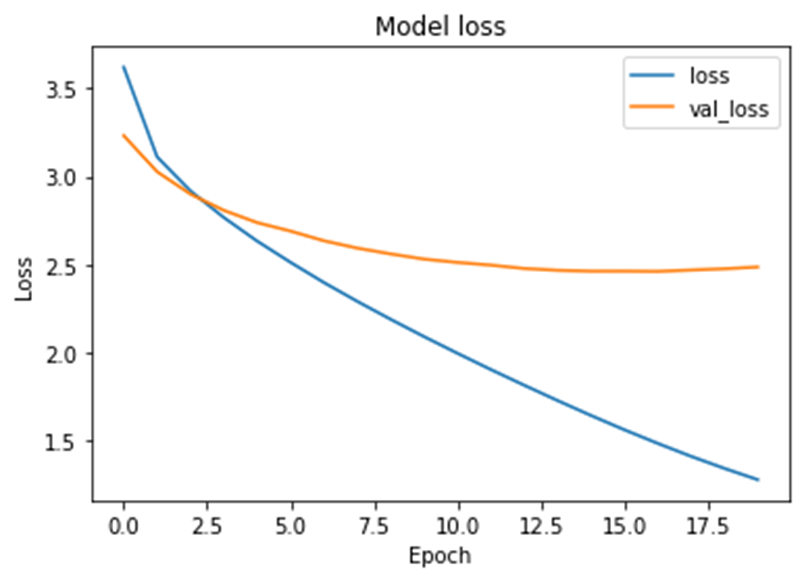

Trial 3
---
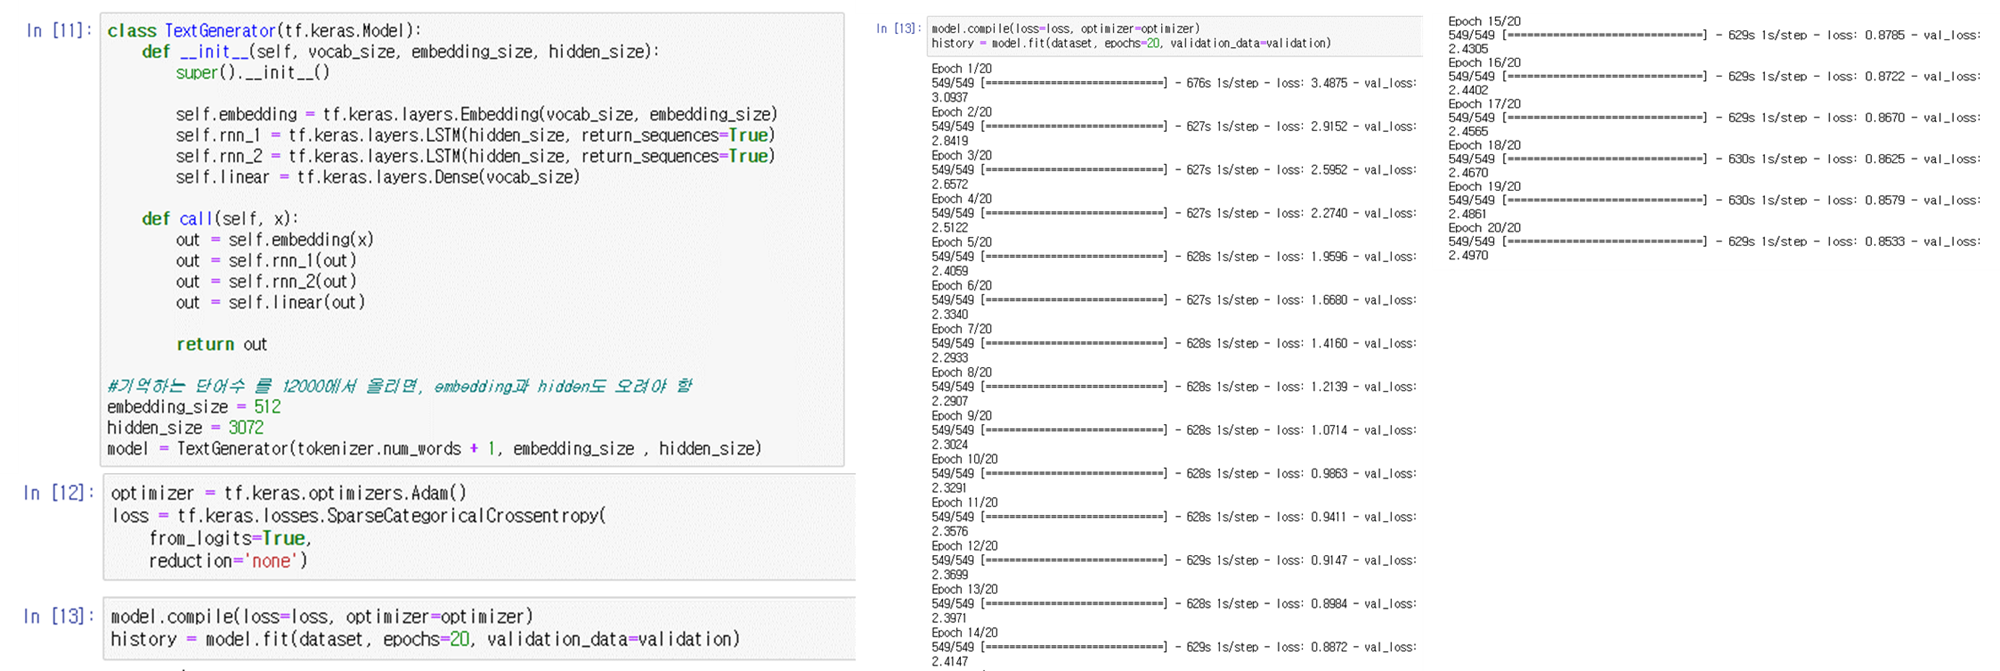
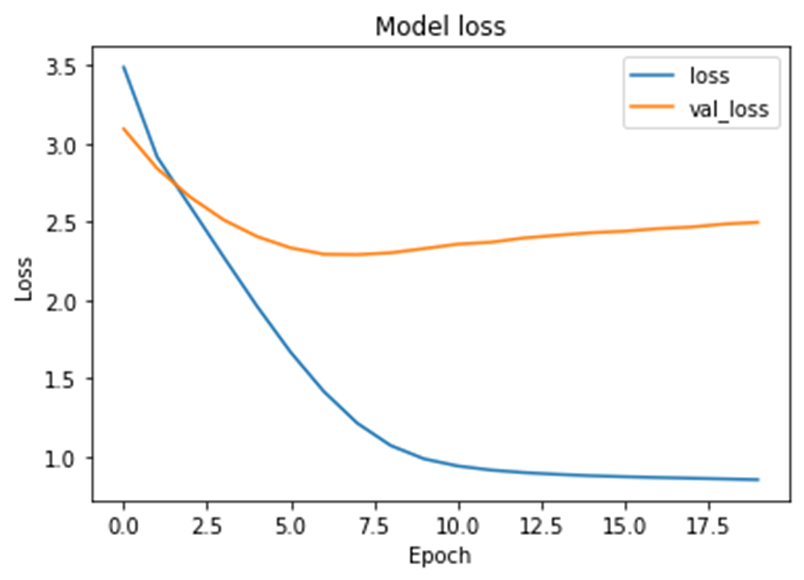

Trial 4
---
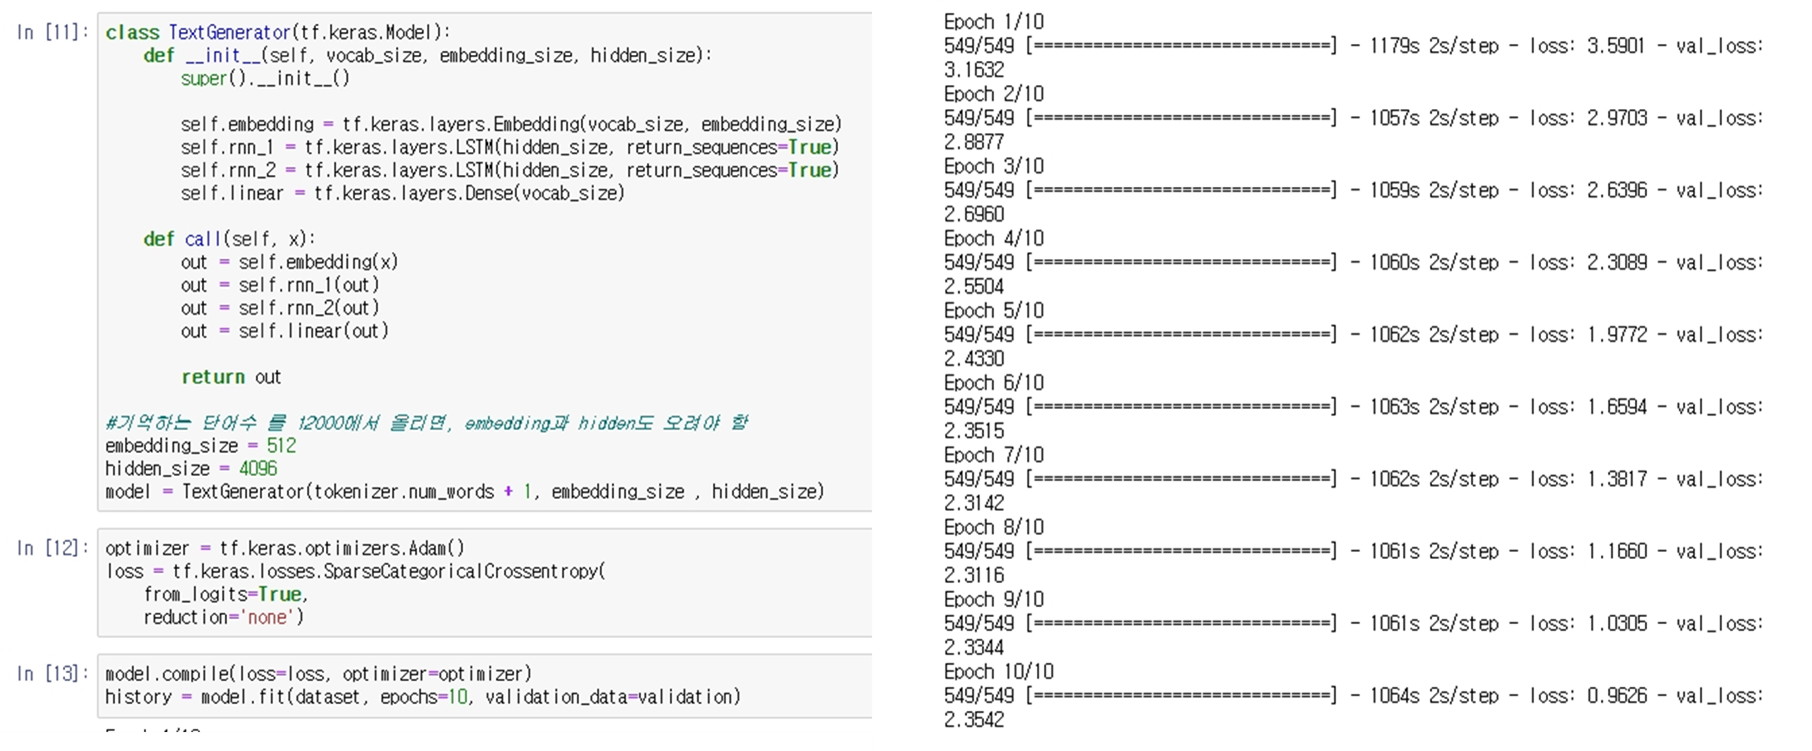
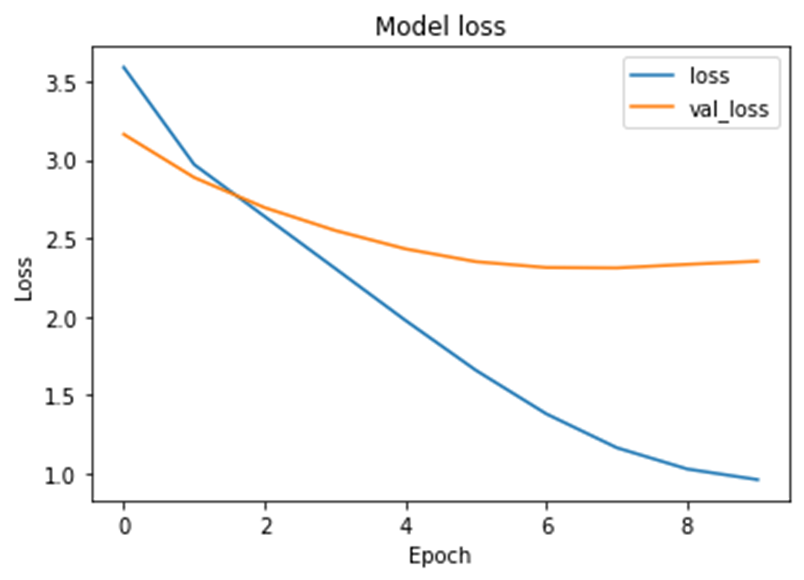

Trial 5
---
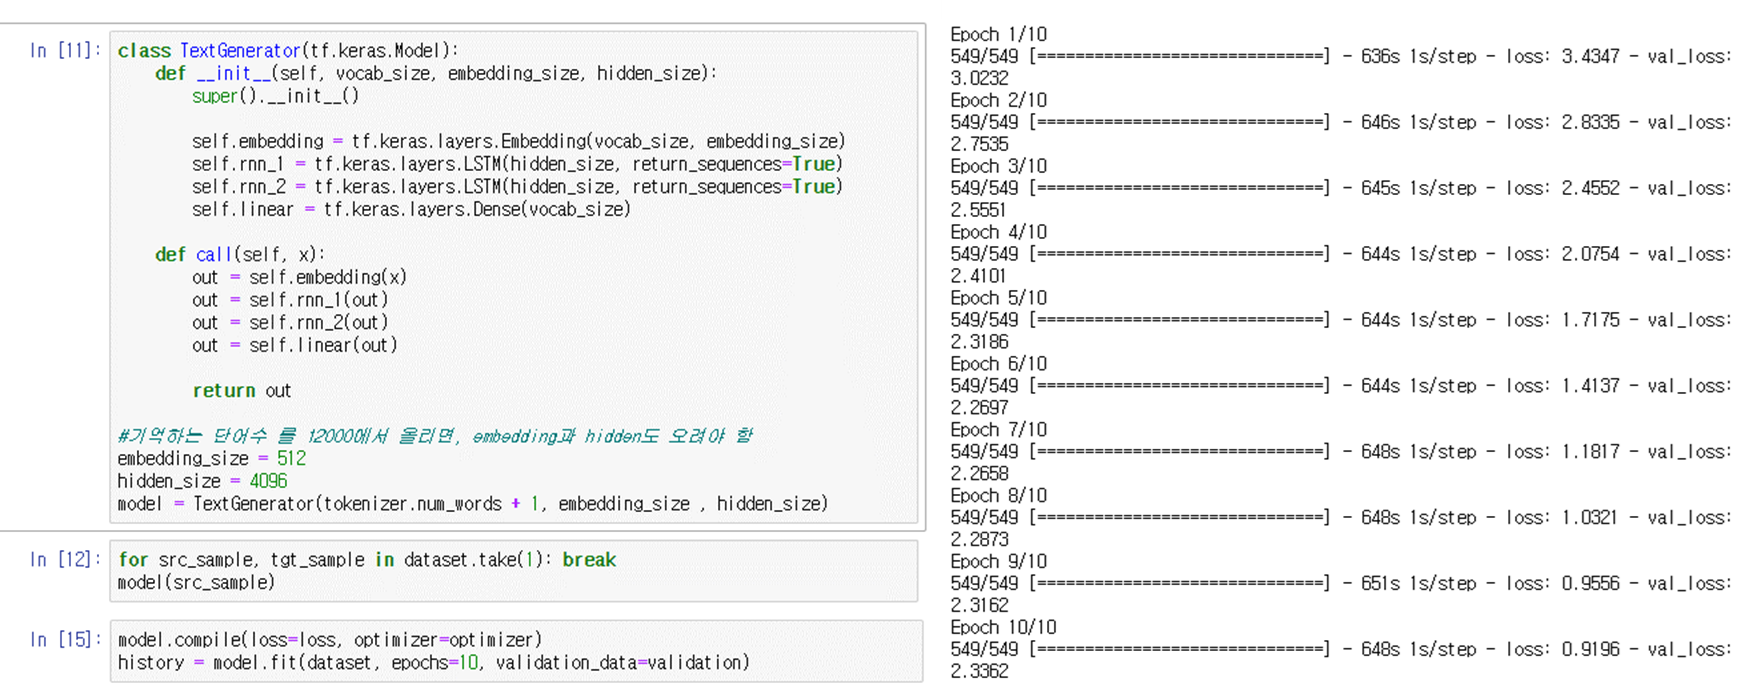
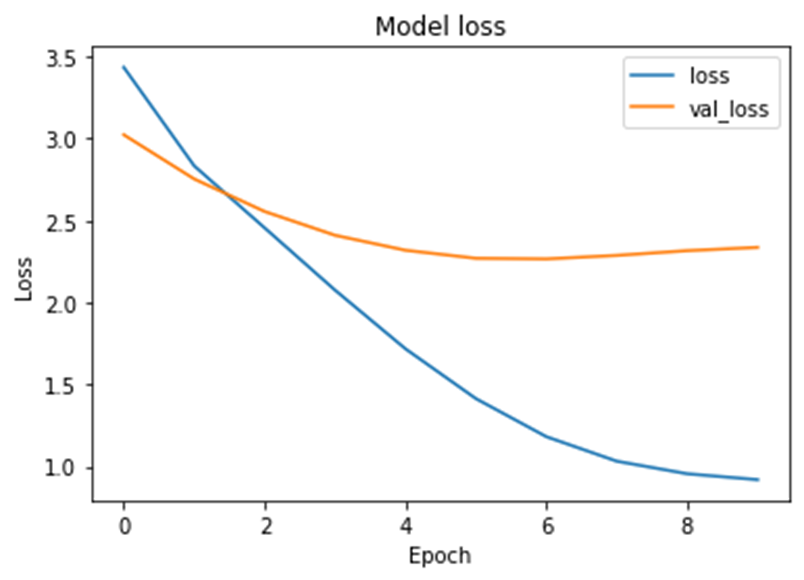